# Google Cloud CMIP6 Public Data: Basic Python Example

This notebooks shows how to query the catalog and load the data using python

In [195]:
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

In [196]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import ssl
import certifi
import os

# 로컬 환경에서 SSL 인증서 문제 해결 (Colab에서는 필요 없음)
# Mac 환경에서 Python이 시스템 인증서를 찾지 못하는 문제 해결
# 두 가지 방법 모두 시도:
# 1. certifi의 인증서 사용
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

# 2. Python의 기본 SSL 컨텍스트 설정 (검증 비활성화 - 로컬 개발용)
# 주의: 프로덕션 환경에서는 사용하지 마세요!
ssl._create_default_https_context = ssl._create_unverified_context

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [197]:
plt.rcParams['figure.figsize'] = 12, 6

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [198]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


The columns of the dataframe correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q).

Here we filter the data to find monthly surface air temperature for historical experiments.

In [199]:
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
973,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1766,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22185,CMIP,IPSL,IPSL-CM6A-LR,historical,r8i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
22298,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
...,...,...,...,...,...,...,...,...,...,...,...
522952,CMIP,MRI,MRI-ESM2-0,historical,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210813
523274,CMIP,MRI,MRI-ESM2-0,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210907
523712,CMIP,CMCC,CMCC-CM2-SR5,historical,r3i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211108
523721,CMIP,CMCC,CMCC-CM2-SR5,historical,r2i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211109


Now we do further filtering to find just the models from NCAR.

In [200]:
df_ta_ncar = df_ta.query('institution_id == "NCAR"')
df_ta_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
56049,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56143,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56326,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61862,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63131,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
63266,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64615,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311


## Load Data

Now we will load a single store using gcsfs, zarr, and xarray.

In [201]:
# this only needs to be created once
# 로컬 환경에서 SSL 검증 문제 해결 (Colab에서는 필요 없음)
# gcsfs가 내부적으로 사용하는 aiohttp의 SSL 검증을 우회하기 위한 설정
import ssl
import aiohttp

# 방법 1: aiohttp의 TCPConnector 기본값 변경
# gcsfs가 aiohttp.ClientSession을 생성하기 전에 실행해야 함
ssl_context = ssl.create_default_context()
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

# aiohttp의 기본 SSL 컨텍스트를 비검증 모드로 설정
# 이는 gcsfs가 내부적으로 사용하는 모든 aiohttp 연결에 적용됩니다
import functools
original_TCPConnector = aiohttp.TCPConnector

class PatchedTCPConnector(aiohttp.TCPConnector):
    def __init__(self, *args, **kwargs):
        # ssl 파라미터가 없으면 기본적으로 검증 비활성화
        if 'ssl' not in kwargs:
            kwargs['ssl'] = ssl_context
        super().__init__(*args, **kwargs)

# aiohttp.TCPConnector를 패치된 버전으로 교체
aiohttp.TCPConnector = PatchedTCPConnector

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 110MB
Dimensions:    (time: 1980, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    lat_bnds   (lat, nbnd) float64 2kB ...
    lon_bnds   (lon, nbnd) float64 2kB ...
    time_bnds  (time, nbnd) object 32kB ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 109MB ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           10950.0
    ...                              ...
    sub_experiment_id:               none
    table_id:                        Amon
    tracking_id:                     hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    variable_id:                     tas
    variant_info:                    CMIP6 CESM2-FV2 historical experiment (1...
    variant_label:                   r2i1p1f1

Plot a map from a specific date.

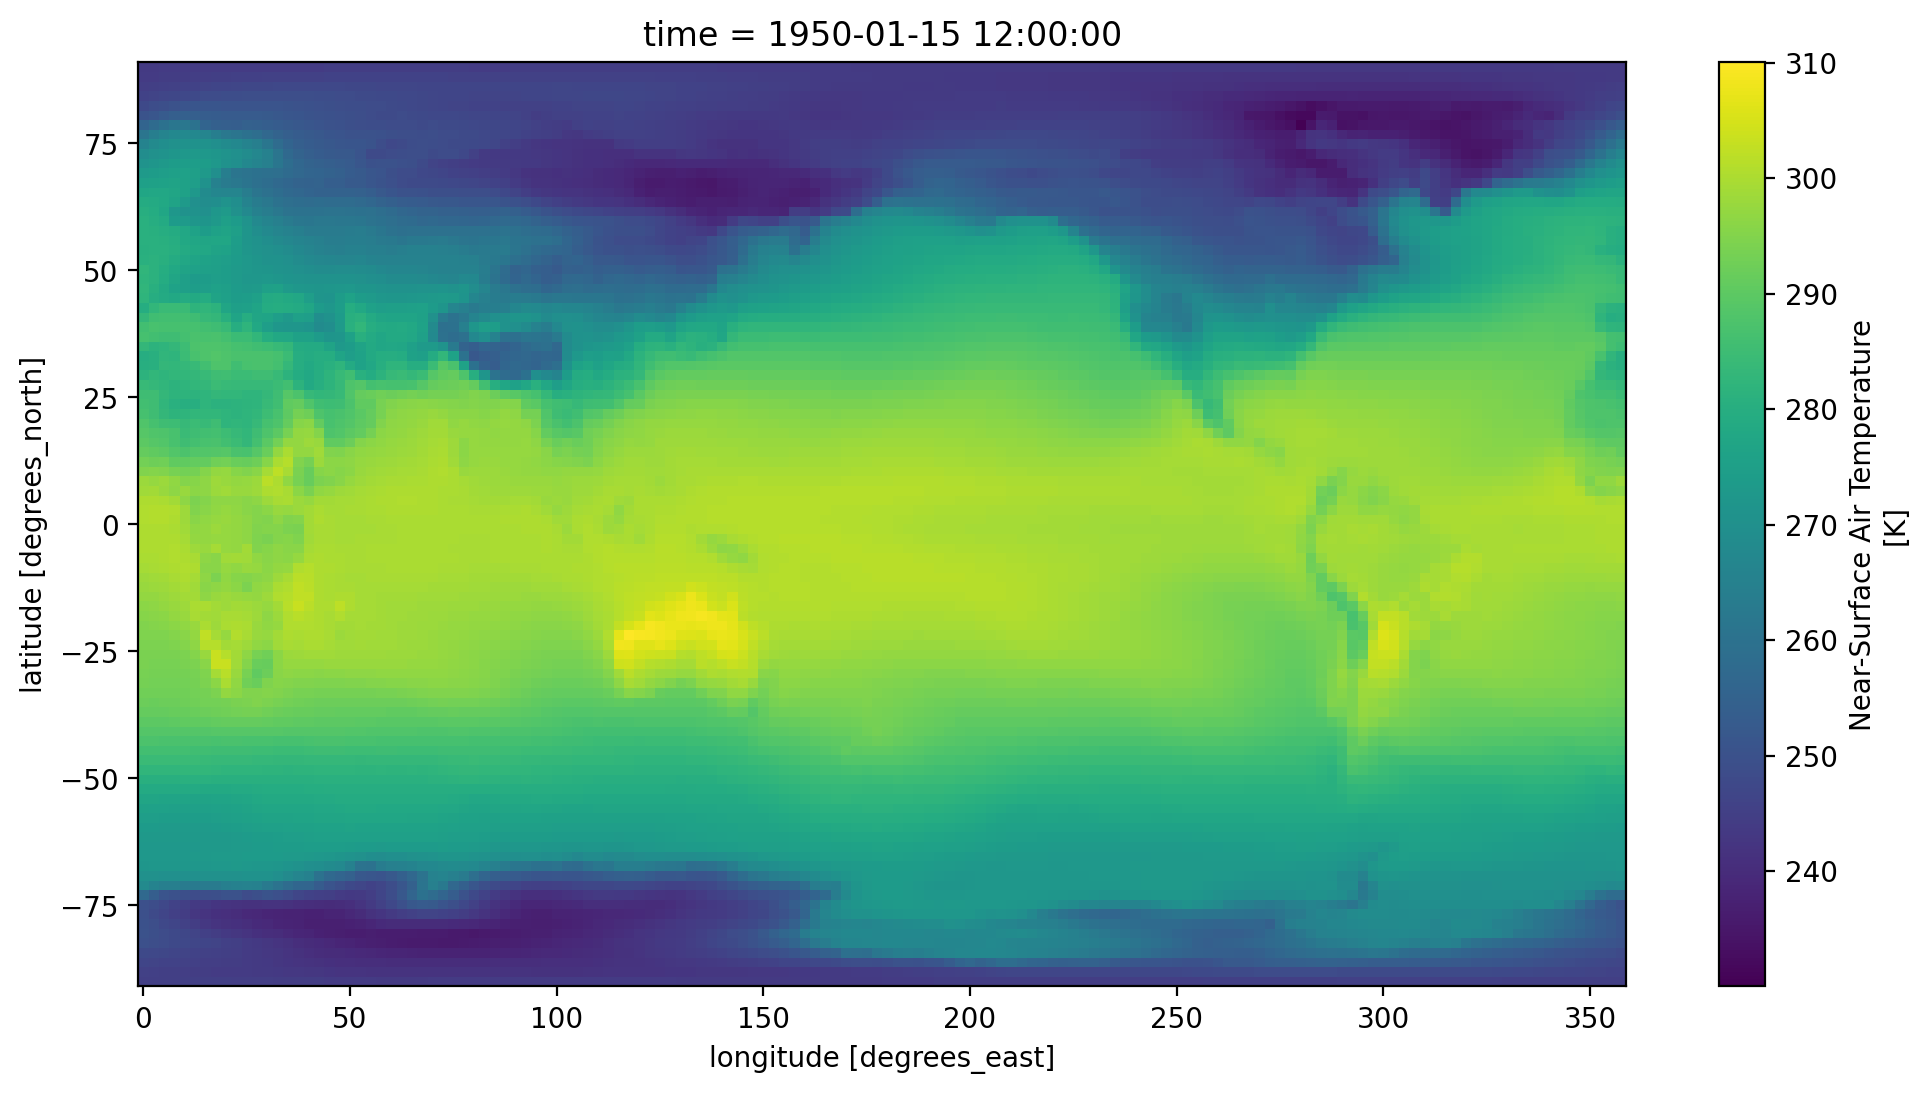

In [202]:
ds.tas.sel(time='1950-01').squeeze().plot()

Create a timeseries of global-average surface air temperature. For this we need the area weighting factor for each gridpoint.

In [203]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset> Size: 229kB
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 221kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                38
    ...                     ...
    table_id:               fx
    tracking_id:            hdl:21.14100/23fa9dc3-4f8f-4943-b99b-58eb804c06f0
    variable_id:            areacella
    variant_info:           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001 
\n
\...
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

In [204]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)> Size: 8kB
array([0.00407822, 0.00405088, 0.0039282 , ..., 0.00411686, 0.00414686,
       0.00418852], shape=(1980,), dtype=float32)
Coordinates:
  * time     (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [205]:
ta_timeseries.load()

<xarray.DataArray (time: 1980)> Size: 8kB
array([0.00407822, 0.00405088, 0.0039282 , ..., 0.00411686, 0.00414686,
       0.00418852], shape=(1980,), dtype=float32)
Coordinates:
  * time     (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

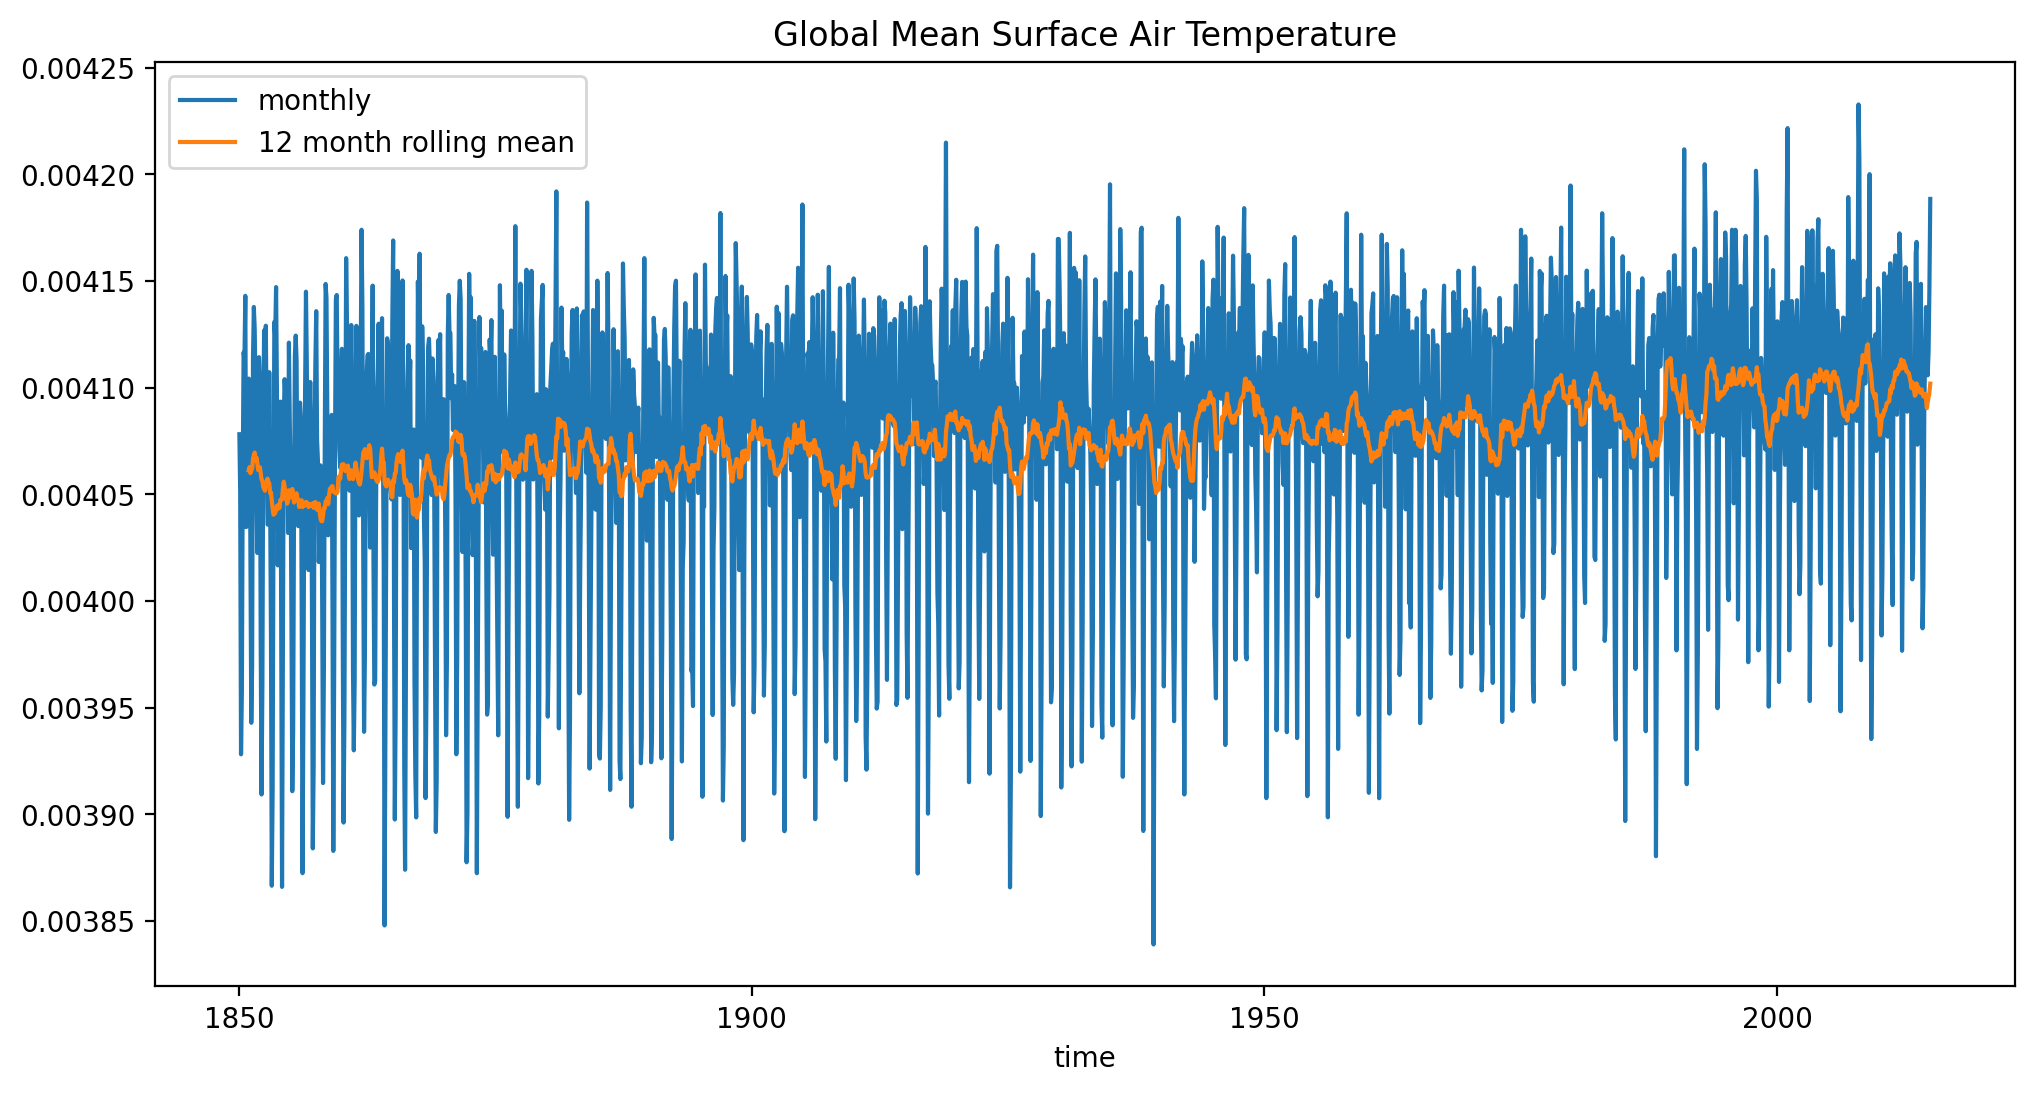

In [206]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')


=== Temperature Heatmap Data ===
Data shape: (13824, 3)
Latitude range: -90.0° to 90.0°
Longitude range: 0.0° to 357.5°
Temperature range: -54.85°C to 31.89°C
Mean temperature: 4.95°C

Saved to: /Users/holim/code/dsc106/project03/cmip6_d3_starter/data/temperature_heatmap.csv


Data years: 1850 to 2014
Created 17 decadal periods
  1850-1859: 96 latitude bands, temp range -48.98°C to 26.39°C
  1860-1869: 96 latitude bands, temp range -48.99°C to 26.44°C
  1870-1879: 96 latitude bands, temp range -48.54°C to 26.42°C
  1880-1889: 96 latitude bands, temp range -49.03°C to 26.39°C
  1890-1899: 96 latitude bands, temp range -48.23°C to 26.50°C
  1900-1909: 96 latitude bands, temp range -48.77°C to 26.48°C
  1910-1919: 96 latitude bands, temp range -48.43°C to 26.52°C
  1920-1929: 96 latitude bands, temp range -48.66°C to 26.52°C
  1930-1939: 96 latitude bands, temp range -48.60°C to 26.48°C
  1940-1949: 96 latitude bands, temp range -48.27°C to 26.62°C
  1950-1959: 96 latitude bands, temp range -48.12°C to 26.55°C
  1960-1969: 96 latitude bands, temp range -48.05°C to 26.40°C
  1970-1979: 96 latitude bands, temp range -48.20°C to 26.49°C
  1980-1989: 96 latitude bands, temp range -48.02°C to 26.59°C
  1990-1999: 96 latitude bands, temp range -47.70°C to 26.83°C
  2

## 1. North vs South Hemispheres Analysis

Compare warming trends between Northern and Southern Hemispheres using area-weighted averages.


In [209]:
# 1. North vs South Hemispheres
# Mask lat >= 0 (Northern Hemisphere) vs lat < 0 (Southern Hemisphere)
# Apply area-weighting and compute anomalies

# Convert Kelvin to Celsius if needed
if ds.tas.values.mean() > 100:
    tas_celsius = ds.tas - 273.15
else:
    tas_celsius = ds.tas

# Northern Hemisphere (lat >= 0)
nh_mask = ds_area.lat >= 0
nh_area = ds_area.areacella.where(nh_mask, 0)
nh_total_area = nh_area.sum(dim=['lon', 'lat'])
nh_timeseries = (tas_celsius * nh_area).sum(dim=['lon', 'lat']) / nh_total_area

# Southern Hemisphere (lat < 0)
sh_mask = ds_area.lat < 0
sh_area = ds_area.areacella.where(sh_mask, 0)
sh_total_area = sh_area.sum(dim=['lon', 'lat'])
sh_timeseries = (tas_celsius * sh_area).sum(dim=['lon', 'lat']) / sh_total_area

# Load data explicitly
nh_timeseries.load()
sh_timeseries.load()

print("Northern Hemisphere timeseries shape:", nh_timeseries.shape)
print("Southern Hemisphere timeseries shape:", sh_timeseries.shape)


Northern Hemisphere timeseries shape: (1980,)
Southern Hemisphere timeseries shape: (1980,)


In [210]:
# Convert to DataFrames and compute monthly anomalies
def to_monthly_df(ts):
    """Convert xarray timeseries to monthly DataFrame"""
    # Convert Kelvin to Celsius if needed
    if ts.values.mean() > 100:
        ts = ts - 273.15
    
    # Convert to pandas DataFrame
    df = ts.to_series().reset_index()
    
    # Handle time column - CMIP6 uses cftime objects, not standard datetime
    # Extract year and month from time values
    def extract_year_month(time_val):
        """Extract year and month from time value (handles cftime and datetime)"""
        if hasattr(time_val, 'year'):
            return time_val.year, time_val.month
        else:
            try:
                dt = pd.to_datetime(time_val)
                return dt.year, dt.month
            except:
                return None, None
    
    # Apply extraction to each time value
    year_month = df["time"].apply(lambda x: extract_year_month(x))
    df["year"] = [ym[0] for ym in year_month]
    df["month"] = [ym[1] for ym in year_month]
    
    # Rename temperature column
    df = df.rename(columns={df.columns[1]: "temp_c"})
    return df

def monthly_anomaly(df, base_start=1850, base_end=1900):
    """Compute monthly anomalies relative to baseline"""
    base = df[(df["year"] >= base_start) & (df["year"] <= base_end)]
    if base.empty:
        base = df[(df["year"] >= 1961) & (df["year"] <= 1990)]
    clim = base.groupby("month")["temp_c"].mean().rename("clim_c").reset_index()
    out = df.merge(clim, on="month", how="left")
    out["anom_c"] = out["temp_c"] - out["clim_c"]
    return out

# Process both hemispheres
nh_df = to_monthly_df(nh_timeseries)
sh_df = to_monthly_df(sh_timeseries)

nh_df_anom = monthly_anomaly(nh_df)
sh_df_anom = monthly_anomaly(sh_df)

# Add hemisphere labels
nh_df_anom["hemisphere"] = "Northern"
sh_df_anom["hemisphere"] = "Southern"

# Combine for visualization
hemisphere_df = pd.concat([nh_df_anom, sh_df_anom], ignore_index=True)

# Annual anomalies
nh_annual = nh_df_anom.groupby("year")["anom_c"].mean().reset_index()
nh_annual["hemisphere"] = "Northern"
sh_annual = sh_df_anom.groupby("year")["anom_c"].mean().reset_index()
sh_annual["hemisphere"] = "Southern"

hemisphere_annual = pd.concat([nh_annual, sh_annual], ignore_index=True)

print("Hemisphere data prepared:")
print(hemisphere_annual.head(10))


Hemisphere data prepared:
   year    anom_c hemisphere
0  1850  0.000007   Northern
1  1851 -0.000005   Northern
2  1852 -0.000019   Northern
3  1853 -0.000024   Northern
4  1854 -0.000005   Northern
5  1855 -0.000023   Northern
6  1856 -0.000025   Northern
7  1857 -0.000032   Northern
8  1858 -0.000016   Northern
9  1859 -0.000017   Northern


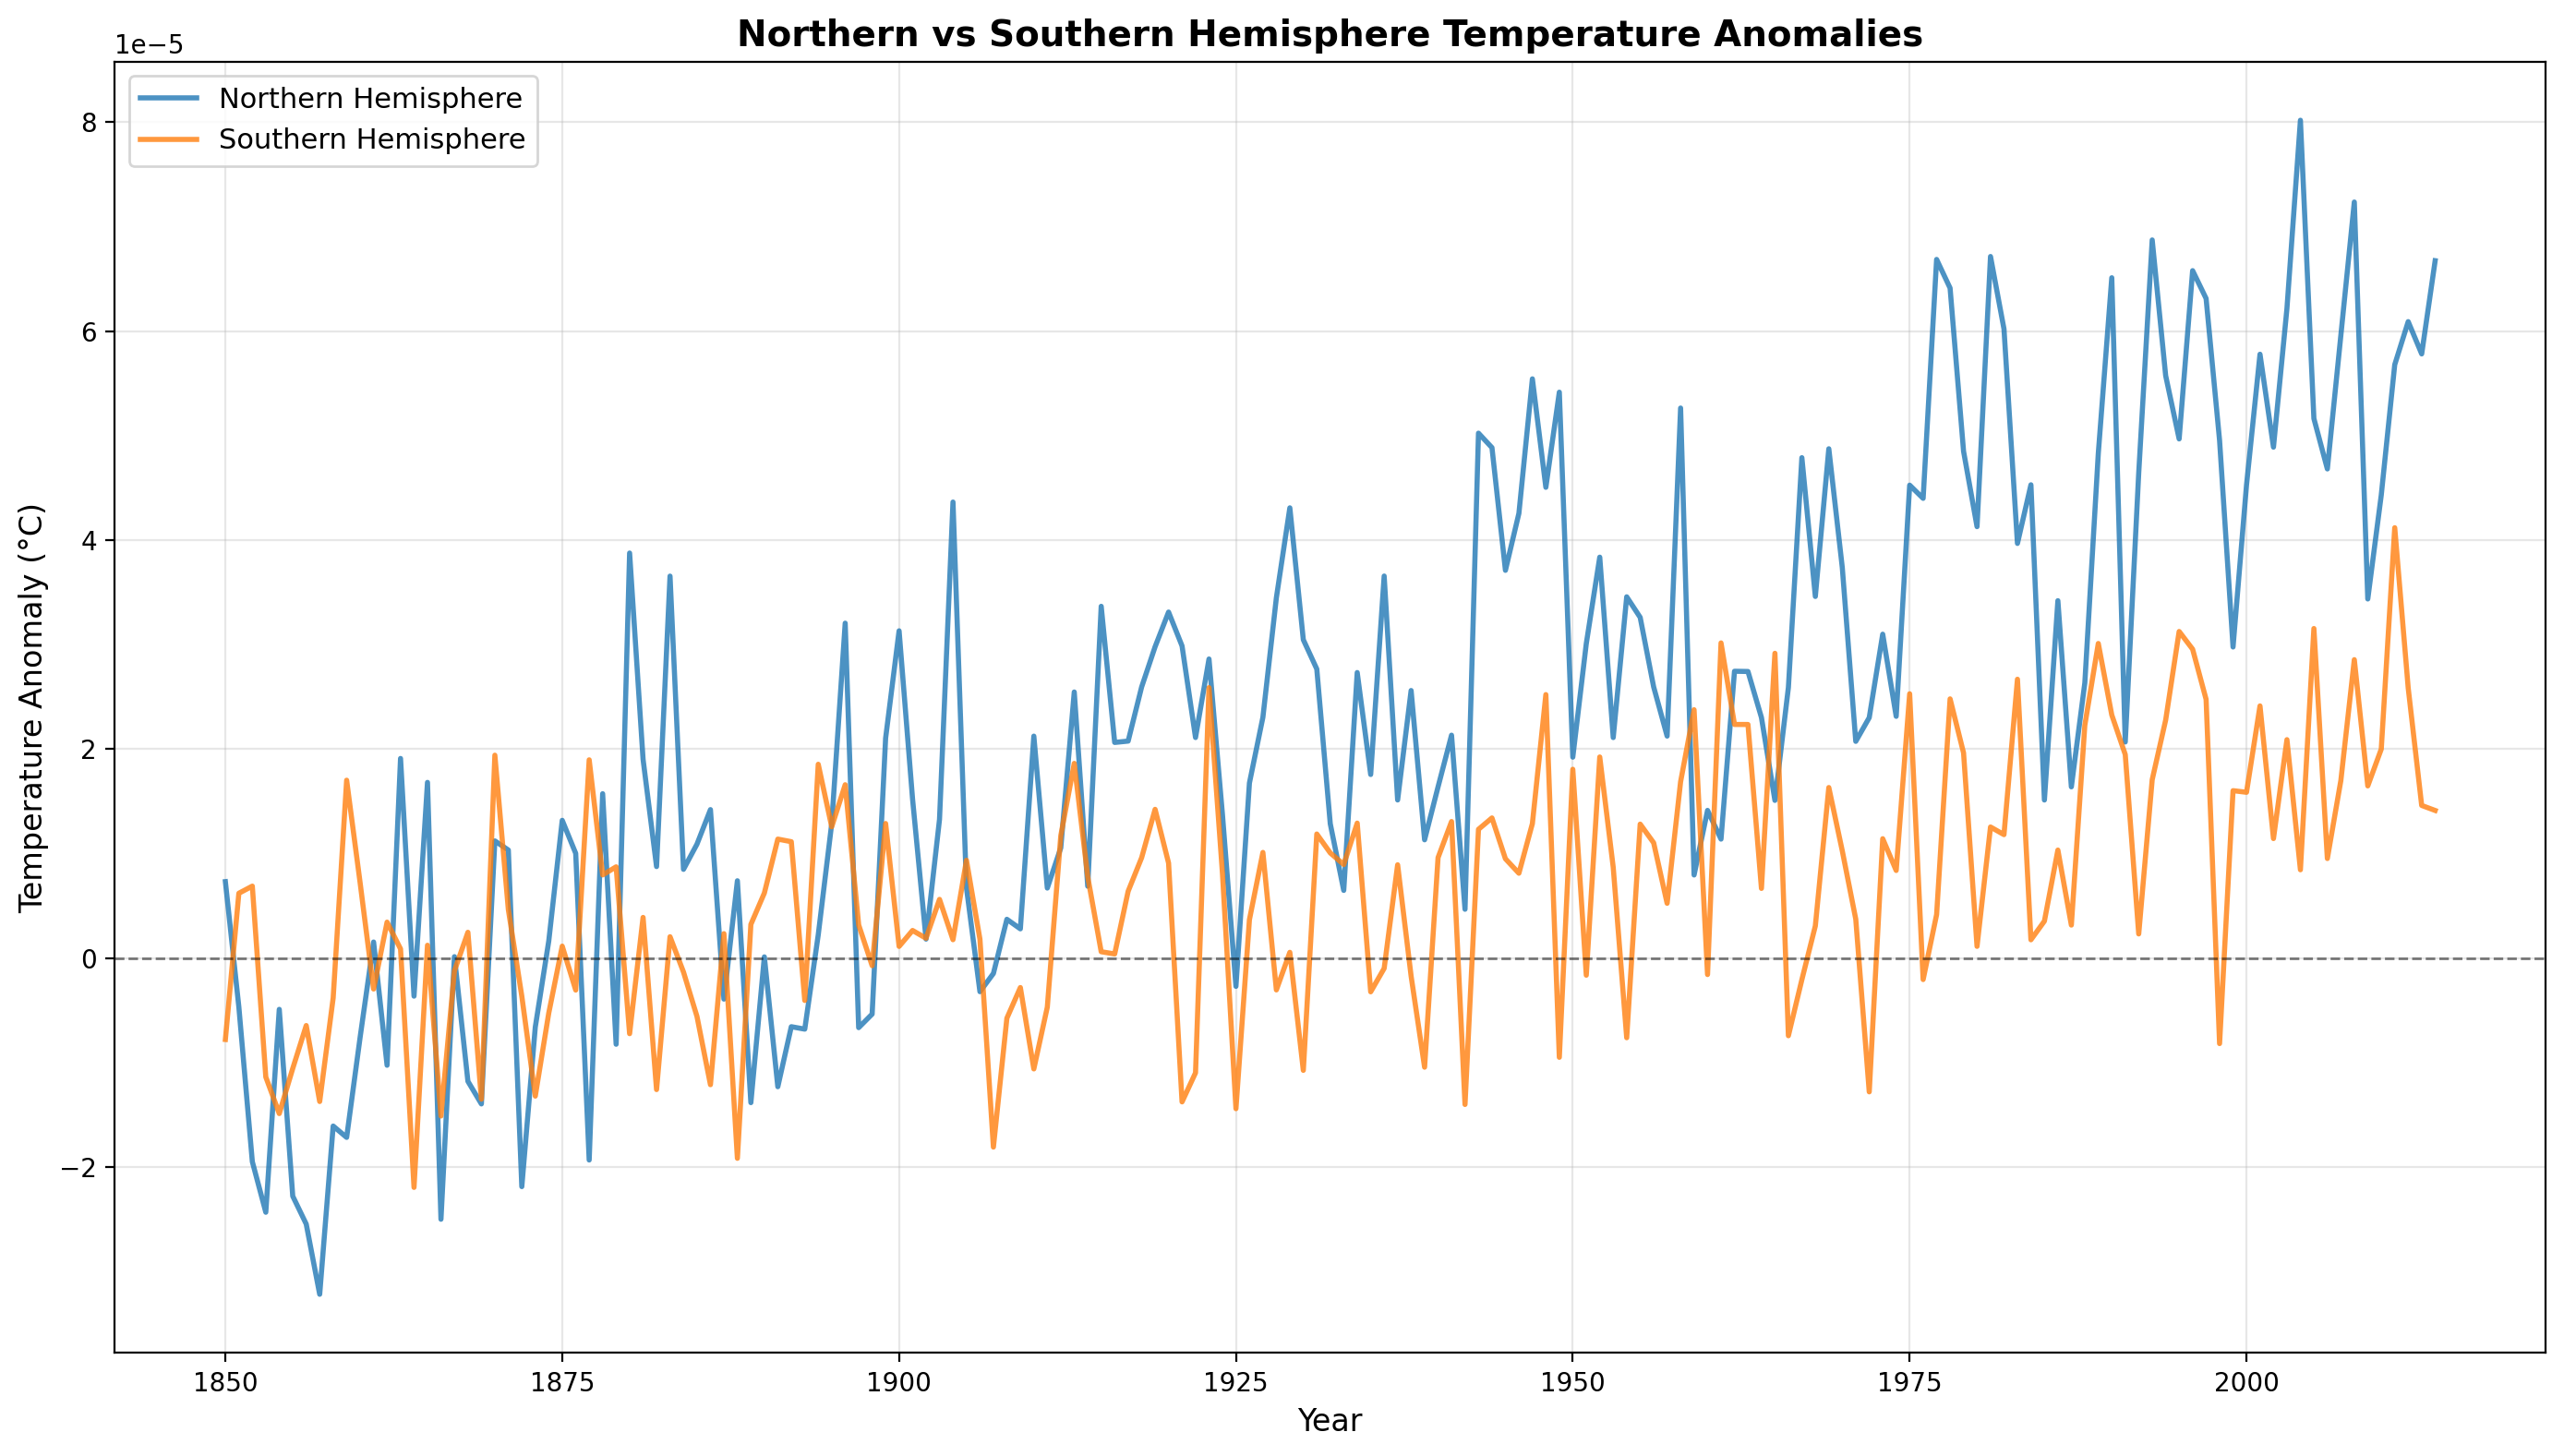

Saved to: /Users/holim/code/dsc106/project03/cmip6_d3_starter/data/hemisphere_anomalies.csv


In [211]:
# Visualize Northern vs Southern Hemisphere anomalies
fig, ax = plt.subplots(figsize=(14, 8))

# Plot annual anomalies (only two lines, one for each hemisphere)
for hem in ["Northern", "Southern"]:
    data = hemisphere_annual[hemisphere_annual["hemisphere"] == hem]
    ax.plot(data["year"], data["anom_c"], label=f"{hem} Hemisphere", linewidth=2, alpha=0.8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature Anomaly (°C)", fontsize=12)
ax.set_title("Northern vs Southern Hemisphere Temperature Anomalies", fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save to CSV
# Ensure data directory exists
os.makedirs("data", exist_ok=True)

# Save file (relative path since notebook is already in cmip6_d3_starter folder)
csv_path = "data/hemisphere_anomalies.csv"
hemisphere_annual.to_csv(csv_path, index=False)
print(f"Saved to: {os.path.abspath(csv_path)}")
